# Chocolate Chip Cookies vs Raisin Cookies Image Classification

Our goal is to train a model that saves humanity from the repeated tragedy:

![cookies](https://github.com/cstorm125/choco-raisin/blob/main/images/choco_raisin_meme.jpg?raw=1)

We train a chocalate chip cookies vs raisin cookies image classifier with data obtained from [DuckDuckGo](http://duckduckgo.com/) image search. We obtained over 90% accruacy in the validation set. Train-validation split and label distribution are as follows:

```
- images
    - train
        -chocolate chip (572 images)
        - raisin (570 images)
    - valid
        -chocolate chip (144 images)
        - raisin (140 images)
```

## Installs and Imports

In [1]:
#install fastai2
!pip install -Uqq fastbook wandb
import fastbook

     |████████████████████████████████| 727kB 20.6MB/s 
     |████████████████████████████████| 2.1MB 48.7MB/s 
     |████████████████████████████████| 1.2MB 43.8MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 194kB 57.3MB/s 
     |████████████████████████████████| 133kB 59.3MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 163kB 50.7MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 246kB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [2]:
#imports
from fastbook import *
from fastai.vision.widgets import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import SaveModelCallback

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from plotnine import *
import shutil
import wandb

import warnings
warnings.filterwarnings('ignore')

## Dataset from Repository

Get dataset from [cstorm125/choco-raisin](https://github.com/cstorm125/choco-raisin). Images are downloaded with `download_images.ipynb` and split with `train_valid_splits.ipynb`.

In [27]:
#use this if you are running on colab
!npx degit github:cstorm125/choco-raisin#main choco-raisin
path = Path('choco-raisin/images')

# #use this instead if you are running on local
# path = Path('../images')

npx: installed 1 in 0.742s
> cloned cstorm125/choco-raisin#main to choco-raisin


## Train-validation-test Split

In order to make sure we do not overfit the validation set, we can furhter split the validation set of 284 images into a test set. This way, we can optimize the models based on validation set and **really** test on th test set.

In [26]:
!rm -r choco-raisin

In [28]:
!mkdir 'choco-raisin/images/test'
!mkdir 'choco-raisin/images/test/chocolate chip'
!mkdir 'choco-raisin/images/test/raisin'

In [29]:
valid_raisin = sorted(list((path/'valid'/'raisin').glob('*')))
valid_choco = sorted(list((path/'valid'/'chocolate chip').glob('*')))
len(valid_raisin), len(valid_choco), valid_raisin[:5], valid_choco[:5]

(140,
 144,
 [Path('choco-raisin/images/valid/raisin/00000007.jpg'),
  Path('choco-raisin/images/valid/raisin/00000009.jpg'),
  Path('choco-raisin/images/valid/raisin/00000011.jpg'),
  Path('choco-raisin/images/valid/raisin/00000013.jpg'),
  Path('choco-raisin/images/valid/raisin/00000014.jpg')],
 [Path('choco-raisin/images/valid/chocolate chip/00000001.jpg'),
  Path('choco-raisin/images/valid/chocolate chip/00000003.jpg'),
  Path('choco-raisin/images/valid/chocolate chip/00000004.jpg'),
  Path('choco-raisin/images/valid/chocolate chip/00000011.jpg'),
  Path('choco-raisin/images/valid/chocolate chip/00000013.jpg')])

In [37]:
#randomly pick about half of validation set for test set
np.random.seed(1412)
test_raisin = np.random.choice(valid_raisin, size=len(valid_raisin)//2, replace=False)
test_choco = np.random.choice(valid_choco, size=len(valid_choco)//2, replace=False)
test_raisin[:10], test_choco[:10], len(test_raisin), len(test_choco)

(array([Path('choco-raisin/images/valid/raisin/00000096.jpg'), Path('choco-raisin/images/valid/raisin/00000266.jpg'), Path('choco-raisin/images/valid/raisin/00000612.jpg'),
        Path('choco-raisin/images/valid/raisin/00000014.jpg'), Path('choco-raisin/images/valid/raisin/00000484.jpg'), Path('choco-raisin/images/valid/raisin/00000182.jpg'),
        Path('choco-raisin/images/valid/raisin/00000799.jpg'), Path('choco-raisin/images/valid/raisin/00000162.jpg'), Path('choco-raisin/images/valid/raisin/00000819.jpg'),
        Path('choco-raisin/images/valid/raisin/00000761.jpg')], dtype=object),
 array([Path('choco-raisin/images/valid/chocolate chip/00000572.jpg'), Path('choco-raisin/images/valid/chocolate chip/00000245.jpg'), Path('choco-raisin/images/valid/chocolate chip/00000001.jpg'),
        Path('choco-raisin/images/valid/chocolate chip/00000568.jpg'), Path('choco-raisin/images/valid/chocolate chip/00000180.jpg'), Path('choco-raisin/images/valid/chocolate chip/00000562.jpg'),
        

In [38]:
for fname in test_raisin:
    shutil.move(str(fname), 'choco-raisin/images/test/raisin')
for fname in test_choco:
    shutil.move(str(fname), 'choco-raisin/images/test/chocolate chip')

In [39]:
#check number of images in validation
len(list((path/'valid'/'raisin').glob('*'))),len(list((path/'valid'/'chocolate chip').glob('*')))

(70, 72)

In [40]:
#check number of images in test
len(list((path/'test'/'raisin').glob('*'))),len(list((path/'test'/'chocolate chip').glob('*')))

(70, 72)

## From Data to DataLoaders

Construct dataloader from images. We decided to do squish resizing to prevent mistaken cropping of larger images (cropping part of the image where there are neither chocolate chips nor raisins).

In [41]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label
    #two choices for resizing and rationale
    #squishing to prevent cropping places without chips/raisins
    item_tfms=Resize(512, method=ResizeMethod.Squish), 
    # #cropping to preserve image quality; tried and doesn't work - peaked at 0.85 val acc
    # item_tfms=RandomResizedCrop(512),
    batch_tfms=aug_transforms(size=512, flip_vert=True), #standard fastai augmentation at size 512
    )
dls = dblock.dataloaders(path, bs=64) #batch size = 64

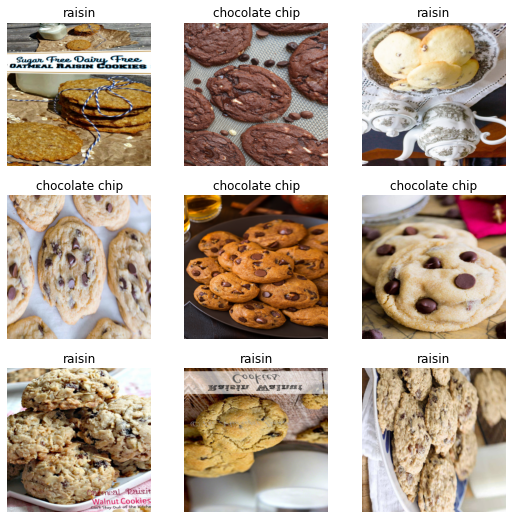

In [42]:
dls.train.show_batch(max_n=9, nrows=3)

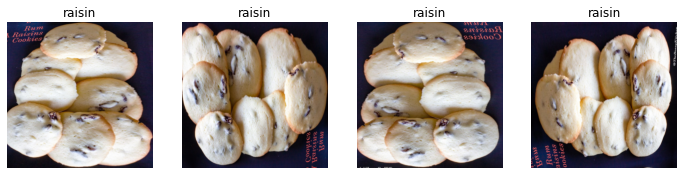

In [43]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Train Model

We use `resnet34` to train the model with validation accuracy as the metric.

In [44]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, 
                             Precision(), 
                             Recall(), 
                             F1Score()]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


We find that `1e-3` seems like a good base learning rate for 1cycle policy.

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=6.309573450380412e-07)

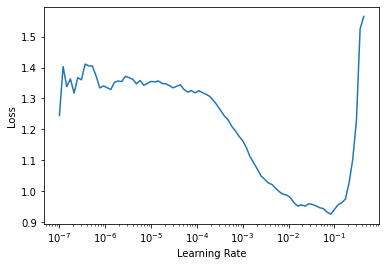

In [45]:
learn.lr_find()

Track metrics and losses using [Weights and Biases](https://wandb.ai/).

In [46]:
wandb.init(project='choco-raisin')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We train for 1 epoch with only the head layer and 5 epochs with all layers. Don't worry about `train_loss` being lower than `valid_loss`; as long as `valid_loss` (and other metrics) continues to improve, we should keep training. In this case, we choose the model with best `f1_score`. Best model is saved at `models/model.pth`.

In [47]:
learn.fine_tune(epochs=5,
          base_lr=1e-3, #max lr; when unfrozen base_lr/2
          freeze_epochs=1, #how many epochs to train frozen
          lr_mult=100, #train feature extractor with max lr at base_lr/lr_mult
          pct_start=0.2, #start decreasing lr at 
          div=5.0, #start at base_lr (max lr) / div
          cbs=[WandbCallback(), #track to wandb
               SaveModelCallback(monitor='f1_score')] #monitor f1 score and save best model
          )

Better model found at epoch 0 with f1_score value: 0.8289473684210527.


Better model found at epoch 0 with f1_score value: 0.823529411764706.
Better model found at epoch 1 with f1_score value: 0.8344370860927153.
Better model found at epoch 2 with f1_score value: 0.8794326241134751.
Better model found at epoch 3 with f1_score value: 0.881118881118881.
Better model found at epoch 4 with f1_score value: 0.896551724137931.


Train and validation losses.

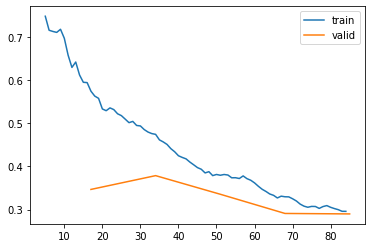

In [48]:
learn.recorder.plot_loss()

Learning rate schedule, starting from base learning rate to max learning rate then gradually decreasing to zero.

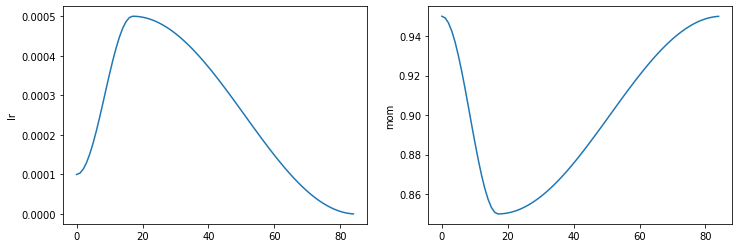

In [54]:
learn.recorder.plot_sched()

Create fastai interpretation object to check validation results.

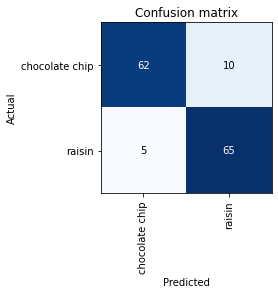

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Images with top losses, aka those that the model was most confident about but got it wrong.

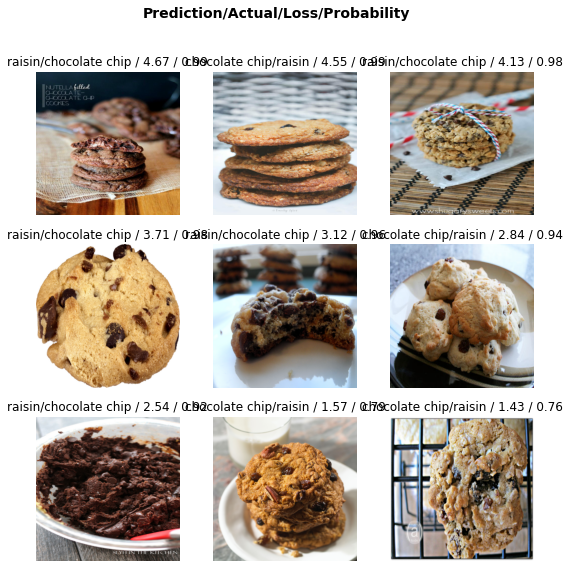

In [51]:
interp.plot_top_losses(9, nrows=3)

In [52]:
interp.print_classification_report()

                precision    recall  f1-score   support

chocolate chip       0.93      0.86      0.89        72
        raisin       0.87      0.93      0.90        70

      accuracy                           0.89       142
     macro avg       0.90      0.89      0.89       142
  weighted avg       0.90      0.89      0.89       142



Random batches of results in validation set (above - ground truth; below - prediction)

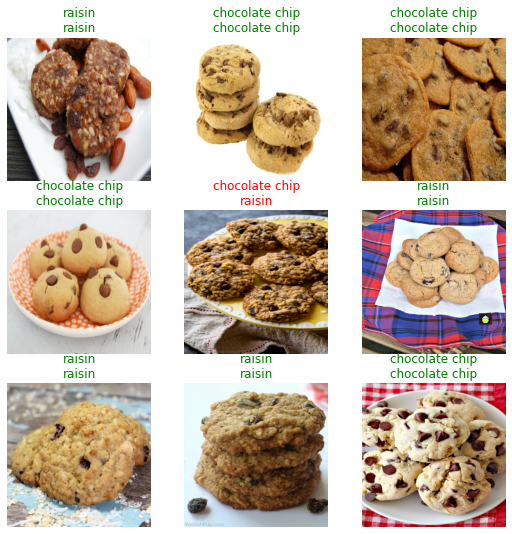

In [73]:
learn.show_results()

## Threshold Optimization

Training a machine learning model is not only about blindly optimizing the loss function; we also need to think about the use case. In this case, if we were to deploy this model to check if we are fooled by a raisin cookies (or chocolate chip cookies if you like raisins more), then the threshold of predicting a class at 0.5 is unlikely to be optimal. 

In this case, cookies that we predict as chocolate chip should almost always be chocolate chip cookies. We are okay turning away some chocolate chip cookies (false negative) as long as our model does not predict raisin cookies as chocolate chip (false positive). In more technical terms, we want a high precision model thus our probability threshold is likely to be higher than 0.5.

Note that this is the opposite case compared to when we need a high recall model such as when we are creating a cancer detection model. We would rather say someone has cancer when they do not (and have them double-checked by human physicians) rather than letting someone who actually has cancer go home thinking they do not have cancer.

Always create a model with a purpose in mind.

In [55]:
precision = Precision()
recall = Recall()
f1 = F1Score()

In [56]:
probs, targs = learn.get_preds()

In [57]:
#col 0 - choco
#col 1 - raisin
probs[-10:] 

tensor([[9.6295e-01, 3.7047e-02],
        [9.9833e-01, 1.6679e-03],
        [9.9998e-01, 2.4395e-05],
        [9.9212e-01, 7.8767e-03],
        [9.9217e-01, 7.8311e-03],
        [8.5373e-01, 1.4627e-01],
        [9.9999e-01, 9.5909e-06],
        [8.4767e-01, 1.5233e-01],
        [9.3177e-01, 6.8226e-02],
        [9.9985e-01, 1.5001e-04]])

In [58]:
#0 - choco
#1 - raisin
targs[-10:]

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

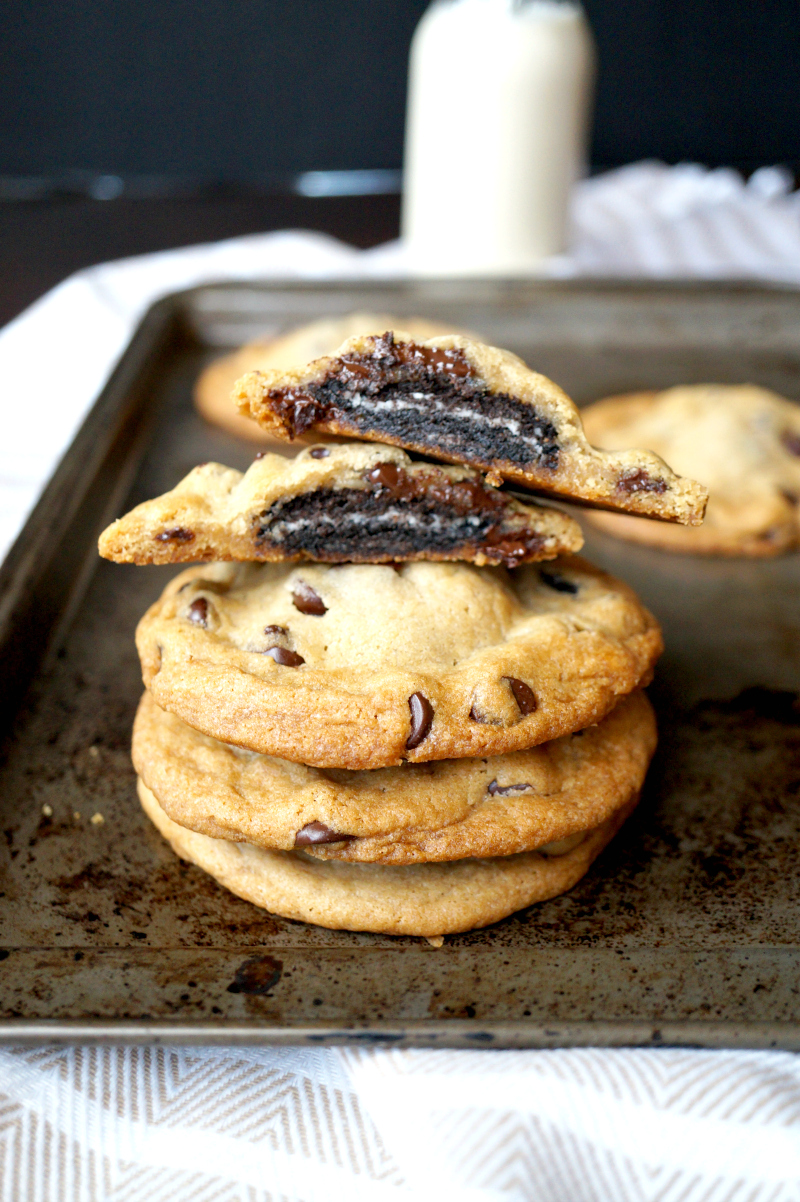

In [59]:
dls.valid_ds[-10][0]

In [60]:
is_choco = (targs-1).abs()
is_choco #1 if choco else 0

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### High Precision Thresholds aka "When we say chocolate chip cookies, we want only chocolate chip cookies"

In [61]:
def metric_finder(labels, probs, metric):
    thres = []
    metrics = []
    predicted_positives = []
    for i in tqdm(range(1,100)):
        thres.append(i/100)
        metrics.append(metric(probs>i/100,labels))
        predicted_positives.append((probs>i/100).sum().item() / labels.shape[0])
    return [list(a) for a in zip(thres,metrics,predicted_positives)]

df = pd.DataFrame(metric_finder(is_choco, probs[:,0],precision))
df.columns = ['threshold','precision','predicted_positive']
df #higher threshold, less images predicted as chocolate chip cookies, and high precision

threshold  precision  predicted_positive
0        0.01   0.696078            0.718310
1        0.02   0.729167            0.676056
2        0.03   0.758242            0.640845
3        0.04   0.766667            0.633803
4        0.05   0.764045            0.626761
..        ...        ...                 ...
94       0.95   0.980000            0.352113
95       0.96   0.979592            0.345070
96       0.97   0.978723            0.330986
97       0.98   0.977273            0.309859
98       0.99   1.000000            0.267606

[99 rows x 3 columns]

In [62]:
df_m = df.melt(id_vars='threshold')
df_m

threshold            variable     value
0         0.01           precision  0.696078
1         0.02           precision  0.729167
2         0.03           precision  0.758242
3         0.04           precision  0.766667
4         0.05           precision  0.764045
..         ...                 ...       ...
193       0.95  predicted_positive  0.352113
194       0.96  predicted_positive  0.345070
195       0.97  predicted_positive  0.330986
196       0.98  predicted_positive  0.309859
197       0.99  predicted_positive  0.267606

[198 rows x 3 columns]

If we want over 95% of what we predict as chocolate chip cookies to be so, we should probably set a threshold of around 0.8 where we will predict about 45% of the validation set as chocolate chip cookies.

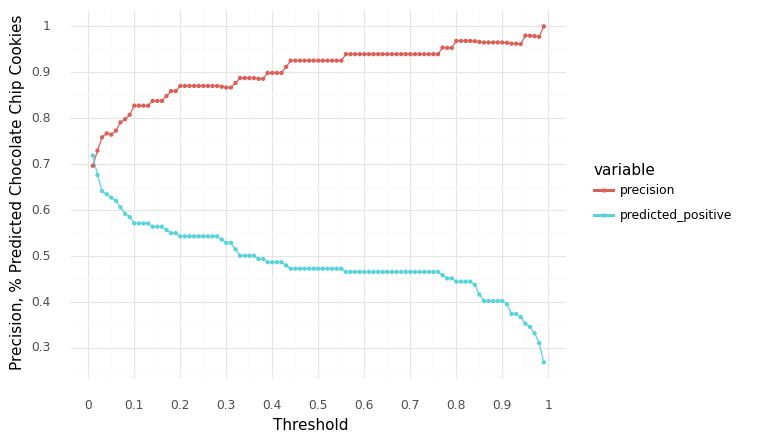

<ggplot: (8742567862217)>

In [63]:
g = (ggplot(df_m, aes(x='threshold',y='value',group='variable',color='variable'))+ 
            geom_line() + geom_point(size=0.75) +
            ylab('Precision, % Predicted Chocolate Chip Cookies') +
            xlab('Threshold') +
            scale_x_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            scale_y_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            theme_minimal())
g

### High Recall Thesholds aka "When we say chocolate chip cookies, we want to get all the chocolate chip cookies, even though we get some raisin cookies mixed in too"

In [64]:
def metric_finder(labels, probs, metric):
    thres = []
    metrics = []
    predicted_positives = []
    for i in tqdm(range(1,100)):
        thres.append(i/100)
        metrics.append(metric(probs>i/100,labels))
        predicted_positives.append((probs>i/100).sum().item() / labels.shape[0])
    return [list(a) for a in zip(thres,metrics,predicted_positives)]

df = pd.DataFrame(metric_finder(is_choco, probs[:,0],recall))
df.columns = ['threshold','recall','predicted_positive']
df #lower threshold, more images predicted as chocolate chip cookies, and high recall

threshold    recall  predicted_positive
0        0.01  0.986111            0.718310
1        0.02  0.972222            0.676056
2        0.03  0.958333            0.640845
3        0.04  0.958333            0.633803
4        0.05  0.944444            0.626761
..        ...       ...                 ...
94       0.95  0.680556            0.352113
95       0.96  0.666667            0.345070
96       0.97  0.638889            0.330986
97       0.98  0.597222            0.309859
98       0.99  0.527778            0.267606

[99 rows x 3 columns]

In [65]:
df_m = df.melt(id_vars='threshold')
df_m

threshold            variable     value
0         0.01              recall  0.986111
1         0.02              recall  0.972222
2         0.03              recall  0.958333
3         0.04              recall  0.958333
4         0.05              recall  0.944444
..         ...                 ...       ...
193       0.95  predicted_positive  0.352113
194       0.96  predicted_positive  0.345070
195       0.97  predicted_positive  0.330986
196       0.98  predicted_positive  0.309859
197       0.99  predicted_positive  0.267606

[198 rows x 3 columns]

At 0.3 threshold, we will have recall of about over 0.9 while predicting about 55% of the validation set as chocolate chip cookies.

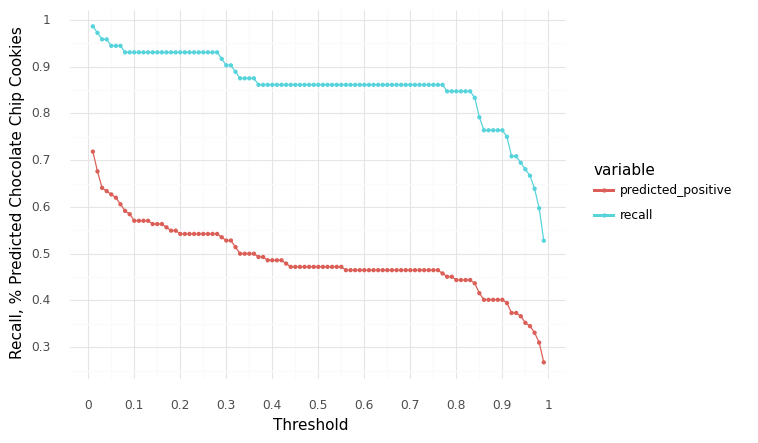

<ggplot: (8742725998569)>

In [66]:
g = (ggplot(df_m, aes(x='threshold',y='value',group='variable',color='variable'))+ 
            geom_line() + geom_point(size=0.75) +
            ylab('Recall, % Predicted Chocolate Chip Cookies') +
            xlab('Threshold') +
            scale_x_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            scale_y_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            theme_minimal())
g

### Best of Both Worlds - High F1 Score

Technically a balance (harmonic mean) between precision and recall, but usually to difficult to interpret for real-life use cases and is more suited to model comparison.

In [67]:
def metric_finder(labels, probs, metric):
    thres = []
    metrics = []
    predicted_positives = []
    for i in tqdm(range(1,100)):
        thres.append(i/100)
        metrics.append(metric(probs>i/100,labels))
        predicted_positives.append((probs>i/100).sum().item() / labels.shape[0])
    return [list(a) for a in zip(thres,metrics,predicted_positives)]

df = pd.DataFrame(metric_finder(is_choco, probs[:,0],f1))
df.columns = ['threshold','f1','predicted_positive']
df 

threshold        f1  predicted_positive
0        0.01  0.816092            0.718310
1        0.02  0.833333            0.676056
2        0.03  0.846626            0.640845
3        0.04  0.851852            0.633803
4        0.05  0.844720            0.626761
..        ...       ...                 ...
94       0.95  0.803279            0.352113
95       0.96  0.793388            0.345070
96       0.97  0.773109            0.330986
97       0.98  0.741379            0.309859
98       0.99  0.690909            0.267606

[99 rows x 3 columns]

In [68]:
df_m = df.melt(id_vars='threshold')
df_m

threshold            variable     value
0         0.01                  f1  0.816092
1         0.02                  f1  0.833333
2         0.03                  f1  0.846626
3         0.04                  f1  0.851852
4         0.05                  f1  0.844720
..         ...                 ...       ...
193       0.95  predicted_positive  0.352113
194       0.96  predicted_positive  0.345070
195       0.97  predicted_positive  0.330986
196       0.98  predicted_positive  0.309859
197       0.99  predicted_positive  0.267606

[198 rows x 3 columns]

It seems like, at 0.5, we are at a reasonably good threshold for F1 score.

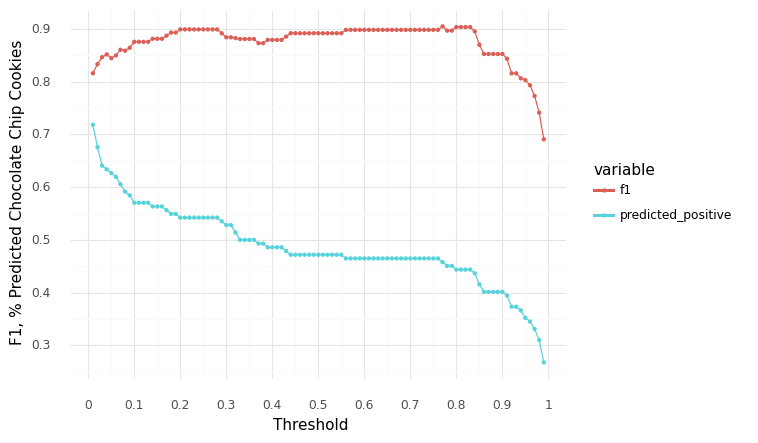

<ggplot: (8742725028601)>

In [69]:
g = (ggplot(df_m, aes(x='threshold',y='value',group='variable',color='variable'))+ 
            geom_line() + geom_point(size=0.75) +
            ylab('F1, % Predicted Chocolate Chip Cookies') +
            xlab('Threshold') +
            scale_x_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            scale_y_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            theme_minimal())
g

## Test Set Performance

Once we have finetuned our models and perform all necessary optimizations, we see the actual performance on the test set. You should do this only once in any machine learning project to prevent overfitting to the test set.

In [70]:
#new datablocks and learner
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(valid_name='test'), #use parent folder as train-test split
    get_y=parent_label, #use parent folder as label
    #two choices for resizing and rationale
    #squishing to prevent cropping places without chips/raisins
    item_tfms=Resize(512, method=ResizeMethod.Squish), 
    # #cropping to preserve image quality; tried and doesn't work - peaked at 0.85 val acc
    # item_tfms=RandomResizedCrop(512),
    batch_tfms=aug_transforms(size=512, flip_vert=True), #standard fastai augmentation at size 512
    )
dls = dblock.dataloaders(path, bs=64) #batch size = 64

learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, Precision(), Recall(), F1Score()]).to_fp16()
#load trained model
learn.load('model');

We can see that even if we have a high validation set performance, it is not warrant a high test set performance. This is a common issue for machine learning models in production.

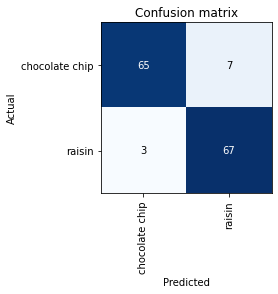

In [71]:
#test set results; our raisin predictions are not very precise
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [72]:
interp.print_classification_report() 

                precision    recall  f1-score   support

chocolate chip       0.96      0.90      0.93        72
        raisin       0.91      0.96      0.93        70

      accuracy                           0.93       142
     macro avg       0.93      0.93      0.93       142
  weighted avg       0.93      0.93      0.93       142



## Turning Your Model into an Online Application

### Using the Model for Inference

Export fastai `learner` for inference.

In [ ]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
#predict a raisin image
learn_inf.predict('choco-raisin/images/test/raisin/00000011.jpg')

('raisin', tensor(1), tensor([2.8970e-04, 9.9971e-01]))

In [ ]:
#predict a chocolate chip image
learn_inf.predict('choco-raisin/images/test/chocolate chip/00000003.jpg')

('chocolate chip', tensor(0), tensor([0.9818, 0.0182]))

In [ ]:
learn_inf.dls.vocab

['chocolate chip', 'raisin']

### Creating a Notebook App from the Model

Run inference app in notebook.

In [ ]:
#upload button
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#image
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#display as 128 * 128
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
#get prediction
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: chocolate chip; Probability: 0.9951')

### Putting Together a Notebook App

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run = widgets.Button(description='Classify Cookies')
btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your cookies!'), 
      btn_upload, btn_run, out_pl, lbl_pred])